[*********************100%%**********************]  1 of 1 completed
C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2612/2612 ━━━━━━━━━━━━━━━━━━━━ 130s 48ms/step - loss: 0.0046
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


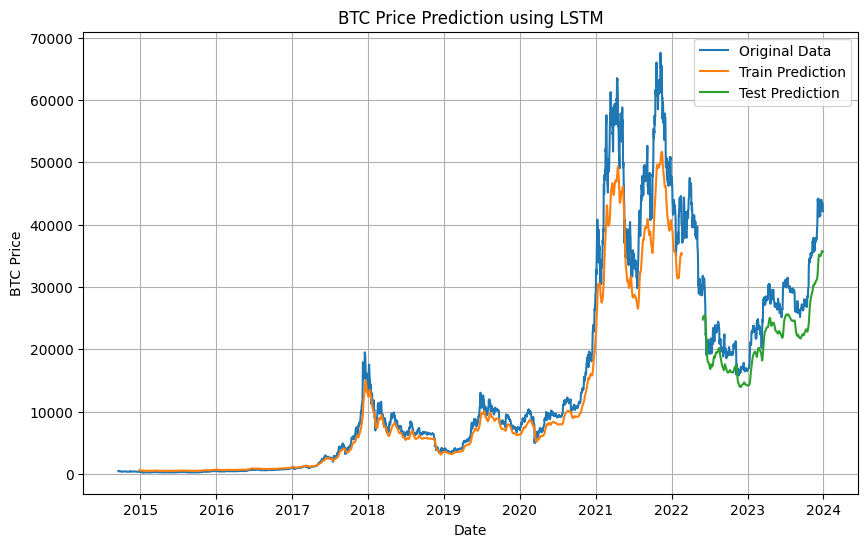

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

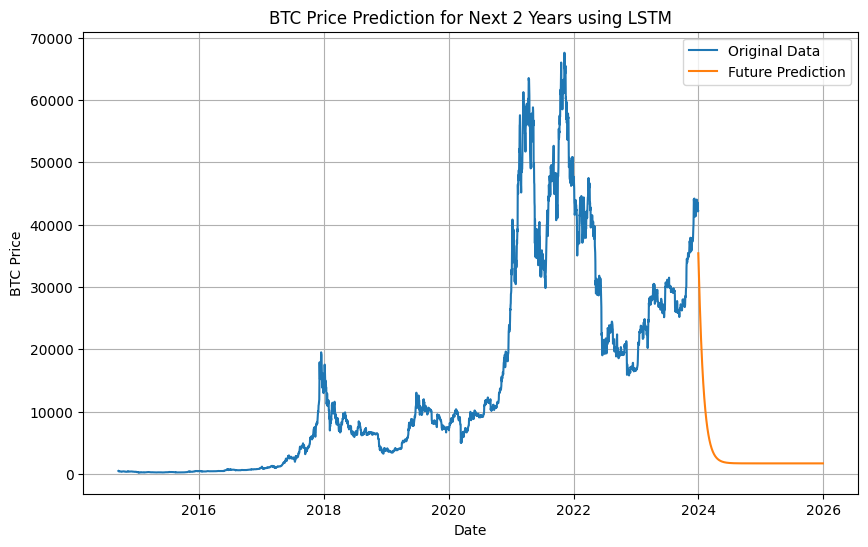

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Fetch BTC data from Yahoo Finance
btc_data = yf.download('BTC-USD', start='2014-01-01', end='2023-12-31')

# Preprocess the data
btc_data = btc_data[['Close']]  # Use only the 'Close' column
dataset = btc_data.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset in time series format
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100  # Choose a time step
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predict the prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(btc_data.index, dataset, label='Original Data')
# Shift train predictions for plotting
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict
# Shift test predictions for plotting
test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1, :] = test_predict
# Plot the predictions
plt.plot(btc_data.index, train_plot, label='Train Prediction')
plt.plot(btc_data.index, test_plot, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction using LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Making two-year prediction
future_steps = 2 * 365  # Predict for 2 years

# Start with the last `time_step` data points from the test set
future_input = test_data[-time_step:]

future_predictions = []
for _ in range(future_steps):
    future_input_reshaped = future_input.reshape((1, time_step, 1))
    future_pred = model.predict(future_input_reshaped)
    future_predictions.append(future_pred[0, 0])
    future_input = np.append(future_input[1:], future_pred[0, 0]).reshape(-1, 1)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a new date range for the future predictions
last_date = btc_data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(btc_data.index, dataset, label='Original Data')
plt.plot(future_dates, future_predictions, label='Future Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction for Next 2 Years using LSTM')
plt.legend()
plt.grid(True)
plt.show()



[*********************100%%**********************]  1 of 1 completed
C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 143s 51ms/step - loss: 0.0048
Epoch 2/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 127s 46ms/step - loss: 5.9671e-04
Epoch 3/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 143s 52ms/step - loss: 3.9207e-04
Epoch 4/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 148s 54ms/step - loss: 3.6827e-04
Epoch 5/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 170s 62ms/step - loss: 3.6777e-04
Epoch 6/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 130s 47ms/step - loss: 3.1905e-04
Epoch 7/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 157s 57ms/step - loss: 2.5987e-04
Epoch 8/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 149s 55ms/step - loss: 2.6525e-04
Epoch 9/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 149s 54ms/step - loss: 2.9089e-04
Epoch 10/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 136s 50ms/step - loss: 2.3182e-04
Epoch 11/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 135s 49ms/step - loss: 2.7515e-04
Epoch 12/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 128s 47ms/step - loss: 3.8886e-04
Epoch 13/20
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 152s 50ms/step - loss: 2.8240e-04
Epoch 14/20


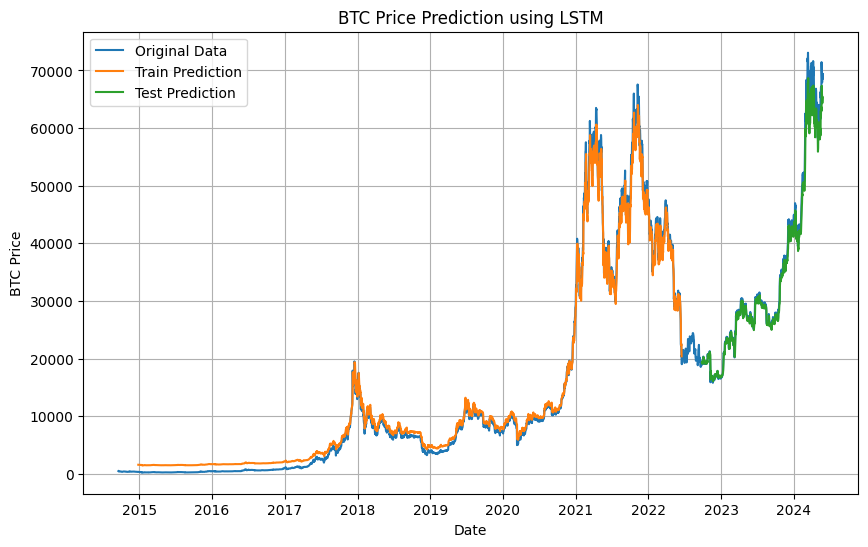

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

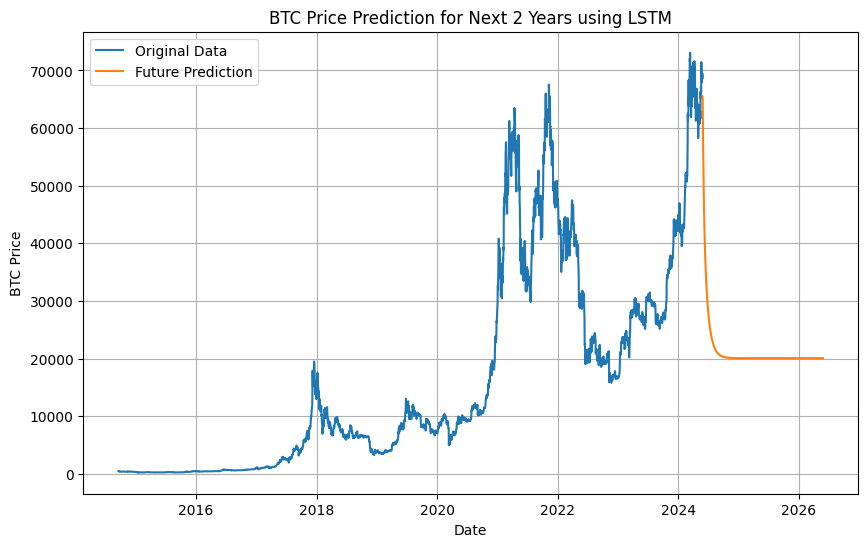

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Fetch BTC data from Yahoo Finance
btc_data = yf.download('BTC-USD', start='2014-01-01', end='2024-05-28')

# Preprocess the data
btc_data = btc_data[['Close']]  # Use only the 'Close' column
dataset = btc_data.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create dataset in time series format
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100  # Choose a time step
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=20)

# Predict the prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
 
# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(btc_data.index, dataset, label='Original Data')
# Shift train predictions for plotting
train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict
# Shift test predictions for plotting
test_plot = np.empty_like(dataset)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1, :] = test_predict
# Plot the predictions
plt.plot(btc_data.index, train_plot, label='Train Prediction')
plt.plot(btc_data.index, test_plot, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction using LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Making two-year prediction
future_steps = 2 * 365  # Predict for 2 years

# Start with the last `time_step` data points from the test set
future_input = test_data[-time_step:]

future_predictions = []
for _ in range(future_steps):
    future_input_reshaped = future_input.reshape((1, time_step, 1))
    future_pred = model.predict(future_input_reshaped)
    future_predictions.append(future_pred[0, 0])
    future_input = np.append(future_input[1:], future_pred[0, 0]).reshape(-1, 1)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a new date range for the future predictions
last_date = btc_data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(btc_data.index, dataset, label='Original Data')
plt.plot(future_dates, future_predictions, label='Future Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction for Next 2 Years using LSTM')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
C:\Users\cyto\AppData\Local\Temp\ipykernel_7292\3901558232.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.index)
C:\Users\cyto\AppData\Local\Temp\ipykernel_7292\3901558232.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Use days since start as the feature
C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493

Mean Squared Error: 222986711.69825786
R-squared: 0.0455502839504085


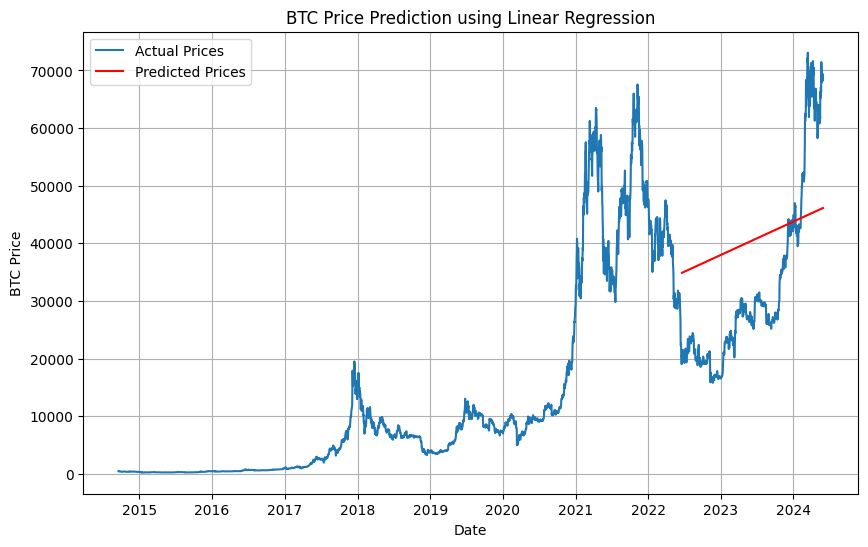

Predicted price for Day 3542: $46142.53


C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Download BTC-USD data
btc_data = yf.download('BTC-USD', start='2014-01-01', end='2024-05-29')

# Select the 'Close' price column
data = btc_data[['Close']]

# Create features (assuming time as the only feature for simplicity)
data['Date'] = pd.to_datetime(data.index)
data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Use days since start as the feature

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Define the linear regression model
model = LinearRegression()

# Train the model on the training data (using 'Day' as the feature)
model.fit(train_data[['Day']], train_data['Close'])

# Make predictions on the testing data
predicted_prices = model.predict(test_data[['Day']].values.reshape(-1, 1))

# Evaluate the model's performance
mse = mean_squared_error(test_data['Close'], predicted_prices)
r2 = r2_score(test_data['Close'], predicted_prices)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Actual Prices')
plt.plot(test_data['Date'], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction using Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# Example prediction for the next day (assuming data goes up to May 29th, 2024)
next_day = data['Day'].iloc[-1] + 1
predicted_price = model.predict([[next_day]])
print(f"Predicted price for Day {next_day}: ${predicted_price[0]:.2f}")


[*********************100%%**********************]  1 of 1 completed
C:\Users\cyto\AppData\Local\Temp\ipykernel_7292\4263921270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.index)
C:\Users\cyto\AppData\Local\Temp\ipykernel_7292\4263921270.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Use days since start as the feature
C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493

Mean Squared Error: 222986711.69825786
R-squared: 0.0455502839504085


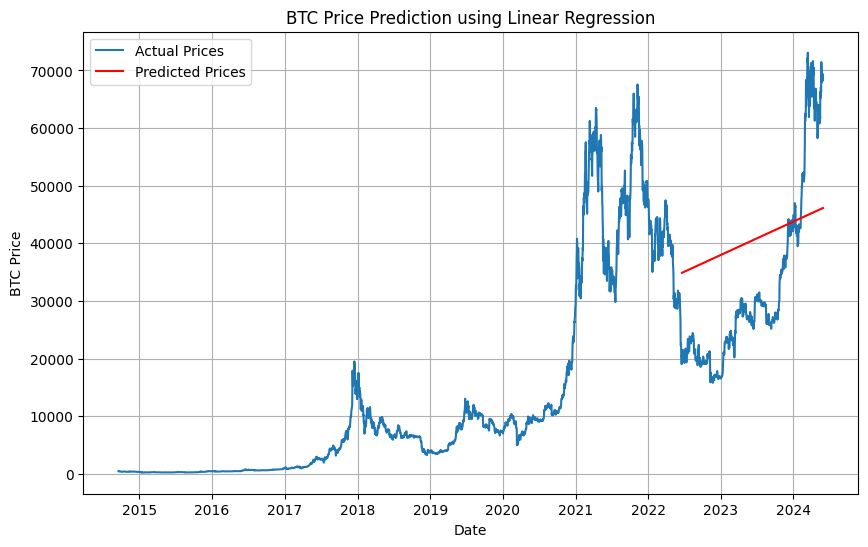

C:\Users\cyto\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Predictions for the next 30 days:
         Date  Predicted_Close
0  2024-05-29     46142.527771
1  2024-05-30     46158.403691
2  2024-05-31     46174.279610
3  2024-06-01     46190.155530
4  2024-06-02     46206.031450
5  2024-06-03     46221.907369
6  2024-06-04     46237.783289
7  2024-06-05     46253.659209
8  2024-06-06     46269.535128
9  2024-06-07     46285.411048
10 2024-06-08     46301.286967
11 2024-06-09     46317.162887
12 2024-06-10     46333.038807
13 2024-06-11     46348.914726
14 2024-06-12     46364.790646
15 2024-06-13     46380.666566
16 2024-06-14     46396.542485
17 2024-06-15     46412.418405
18 2024-06-16     46428.294325
19 2024-06-17     46444.170244
20 2024-06-18     46460.046164
21 2024-06-19     46475.922084
22 2024-06-20     46491.798003
23 2024-06-21     46507.673923
24 2024-06-22     46523.549842
25 2024-06-23     46539.425762
26 2024-06-24     46555.301682
27 2024-06-25     46571.177601
28 2024-06-26     46587.053521
29 2024-06-27     46602.929441


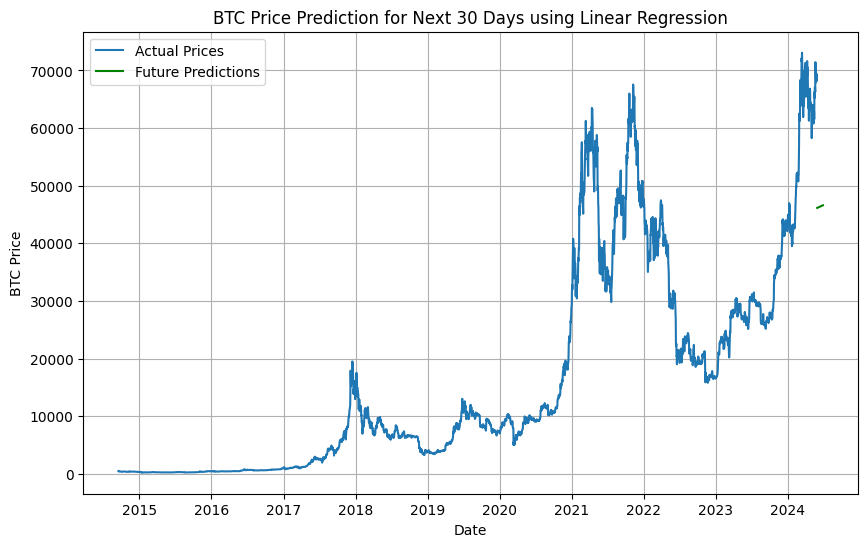

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Download BTC-USD data
btc_data = yf.download('BTC-USD', start='2014-01-01', end='2024-05-29')

# Select the 'Close' price column
data = btc_data[['Close']]

# Create features (assuming time as the only feature for simplicity)
data['Date'] = pd.to_datetime(data.index)
data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Use days since start as the feature

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Define the linear regression model
model = LinearRegression()

# Train the model on the training data (using 'Day' as the feature)
model.fit(train_data[['Day']], train_data['Close'])

# Make predictions on the testing data
predicted_prices = model.predict(test_data[['Day']].values.reshape(-1, 1))

# Evaluate the model's performance
mse = mean_squared_error(test_data['Close'], predicted_prices)
r2 = r2_score(test_data['Close'], predicted_prices)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Actual Prices')
plt.plot(test_data['Date'], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction using Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions for the next 30 days
last_day = data['Day'].iloc[-1]
next_days = list(range(last_day + 1, last_day + 31))
next_day_predictions = model.predict([[day] for day in next_days])

# Create a DataFrame to store future dates and their predicted prices
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Close': next_day_predictions})

print("Predictions for the next 30 days:")
print(future_predictions)

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Actual Prices')
plt.plot(future_predictions['Date'], future_predictions['Predicted_Close'], label='Future Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Price Prediction for Next 30 Days using Linear Regression')
plt.legend()
plt.grid(True)
plt.show()
